# Fish Harvesting Python Implemetantion
This notebook provides a python alternative to the matlab codes in Lenhart and Workman's book. This is intended as a first step in practicing methods I can use to solve OC methods.

## Imports

In [82]:
import numpy as np
import matplotlib.pyplot as plt

## Pontryagin's Maximum Principle

### Define constants

In [83]:
A = 5
k = 10
m = 0.2
x0 = 0.4
M = 1
T = 10
psi_prime = (lambda x: 0)

delta = 0.001
N = 1000
t = np.linspace(0, T, N+1)
h = T/N
h2 = h/2

### Setup for numerical solver

In [84]:
test = -1
u = np.zeros(N+1)
x = np.zeros(N+1)
x[0] = x0
lambda_ = np.zeros(N+1)

### Numerical Solver

In [86]:
while test < 0:
    oldu = u
    oldx = x
    oldlambda_ = lambda_
    
    for i in range(N):
        k1 = -(m + u[i])*x[i]
        k2 = -(m + 0.5*(u[i] + u[i+1]))*(x[i] + h2*k1)
        k3 = -(m + 0.5*(u[i] + u[i+1]))*(x[i] + h2*k2)
        k4 = -(m + u[i+1])*(x[i] + h*k3)
        x[i+1] = x[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    
    lambda_[N] = psi_prime(x[N])
    
    for i in range(N):
        j = N - i
        k1 = -A*u[j]*k*t[j]/(t[j]+1) + lambda_[j]*(m + u[j])
        k2 = -A*0.5*(u[j] + u[j-1])*k*(t[j] - h2)/(t[j] - h2 + 1) \
             + (lambda_[j] - h2 * k1)*(m + 0.5*(u[j] + u[j-1]))
        k3 = -A*0.5*(u[j] + u[j-1])*k*(t[j] - h2) / (t[j] - h2 + 1) \
             + (lambda_[j] - h2*k2)*(m + 0.5*(u[j] + u[j-1]))
        k4 = -A*u[j-1]*k*(t[j] - h)/(t[j] - h + 1) + (lambda_[j] - h*k3)*(m + u[j-1])
        lambda_[j-1] = lambda_[j] - (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    
    temp = -0.5*(lambda_ * x - A*k*t*x/(t+1))
    u1 = np.minimum(M, np.maximum(temp, 0))
    u = 0.5*(u1 + oldu)
    
    temp1 = delta*np.sum(np.abs(u)) - np.sum(np.abs(oldu - u))
    temp2 = delta*np.sum(np.abs(x)) - np.sum(np.abs(oldx - x))
    temp3 = delta*np.sum(np.abs(lambda_)) - np.sum(np.abs(oldlambda_ - lambda_))
    test = min(temp1, temp2, temp3)

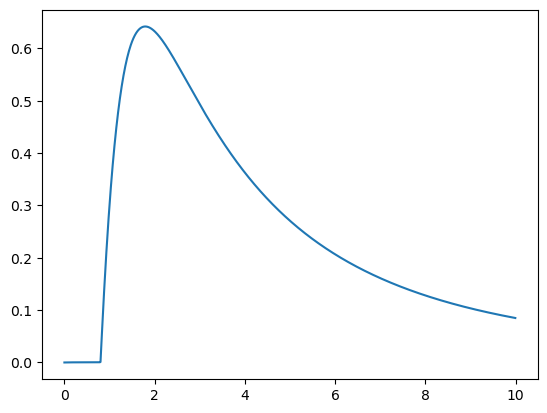

In [87]:
plt.plot(t[:-1], u[:-1])

In [88]:
u[-2]

0.08495160933507918

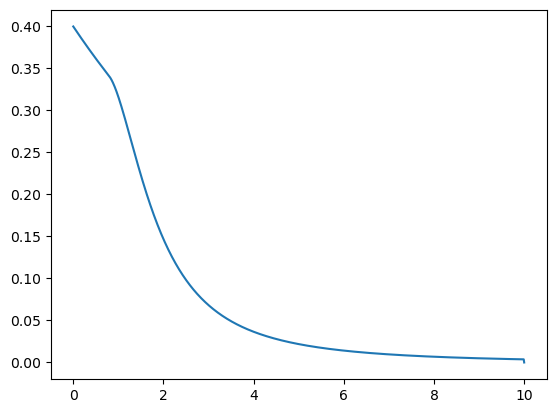

In [6]:
plt.plot(t, x)

In [81]:
x[-2]

0.0037269327709874974

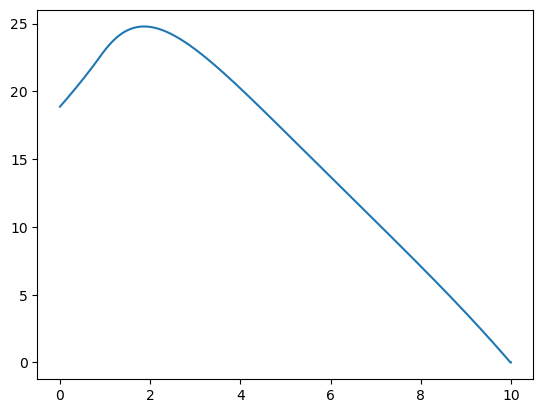

In [7]:
plt.plot(t, lambda_)

## Hamilton-Jacobi-Bellman PDE / Dynamic Programming

In [72]:
m = 0.2
psi = (lambda x: 0*x)
x0 = 0.4
xmin = 0
xmax = 0.5
umin = 0
umax = 1
xnum = 300
unum = 1000
big_num = 10**10
g = (lambda x, t, u: -(m+u)*x)
f = (lambda x, t, y: A*k*(t/(t+1))*x*u - u**2)
h = (xmax - xmin) / (xnum-1)
xx = np.linspace(xmin, xmax, xnum)

tau = h / ((m+umax)*xmax)
tnum = int(np.ceil(T / tau) + 1)
tau = T / (tnum - 1)
tt = np.linspace(0, T, tnum)

uu = np.linspace(umin, umax, unum)

V = -big_num*np.ones((tnum, xnum))
U = (umin - 1) * np.ones((tnum, xnum))
V[tnum-1, :] = psi(xx)

In [73]:
for n in range(tnum-2, 0, -1):
    t = tt[n]
    V_future = V[n+1, :]
    V_future_left = np.concatenate(([big_num], V[n+1, :-1]))
    V_future_right = np.concatenate((V[n+1, 1:], [big_num]))
    BestVal = -np.inf * np.ones(xx.size)
    BestU = (umin-1) * np.ones(xx.size)
    
    for u in uu:
        ff = f(xx, t, u)
        gg = g(xx, t, u)
        shift = tau * gg
        assert(np.sum(np.abs(shift) <= h) == xnum)
        dir_left = (shift < 0)
        dir_right = 1-dir_left
        assert(shift[0] >= 0)
        assert(shift[-1] <= 0)
        
        c_other = np.abs(shift)/h
        c_this = 1 - c_other
        Val = dir_left * (c_other * V_future_left + c_this * V_future) \
            + dir_right * (c_other * V_future_right + c_this * V_future) \
            + tau * ff
        
        new_best = (Val > BestVal)
        BestVal[new_best] = Val[new_best]
        BestU[new_best] = u
    
    V[n, :] = BestVal
    U[n, :] = BestU

In [74]:
V

array([[-1.00000000e+10, -1.00000000e+10, -1.00000000e+10, ...,
        -1.00000000e+10, -1.00000000e+10, -1.00000000e+10],
       [ 0.00000000e+00,  3.30071503e-03,  8.74132735e-03, ...,
         8.38049525e+00,  8.41284144e+00,  8.44519702e+00],
       [ 0.00000000e+00,  3.30255592e-03,  8.74739741e-03, ...,
         8.38585190e+00,  8.41821770e+00,  8.45059288e+00],
       ...,
       [ 0.00000000e+00,  8.04808172e-06,  3.21844251e-05, ...,
         1.20048173e-01,  1.20471143e-01,  1.20894114e-01],
       [ 0.00000000e+00,  4.02547833e-06,  1.61019133e-05, ...,
         6.01300967e-02,  6.03419390e-02,  6.05537813e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [75]:
x_current = x0
x_traj = [x_current]
u_traj = []
Optimal_Value = 0
for n in range(1, tnum):
    t = tt[n]
    
    left_neighb = int(np.floor((x_current - xmin) / h) + 1)
    assert(left_neighb > 0)
    right_neighb = int(left_neighb + 1)
    assert(right_neighb <= xnum)
    
    c_right = (x_current - ( (left_neighb -1)*h + xmin)) / h
    assert(c_right <= 1 and c_right >= 0)
    c_left = 1 - c_right
    u = c_left * U[n, left_neighb] + c_right*U[n, right_neighb]
    
    Optimal_Value = Optimal_Value + tau*f(x_current, t, u)
    x_current = x_current + tau*g(x_current, t, u)
    x_traj.append(x_current)
    u_traj.append(u)

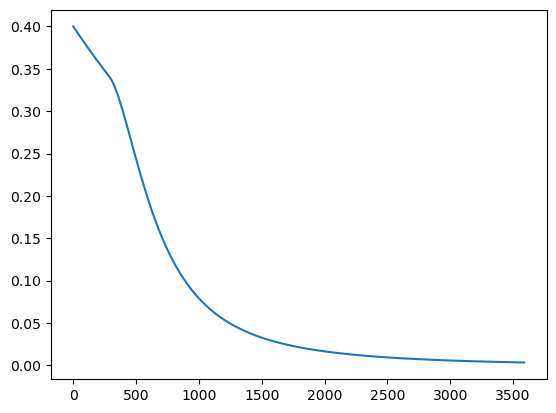

In [76]:
plt.plot(x_traj)

In [79]:
x_traj[-1]

0.003315512161300843

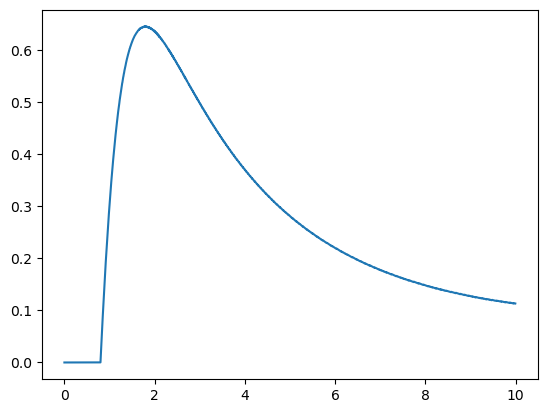

In [77]:
plt.plot(tt[:-2], u_traj[:-1])

In [78]:
u_traj[-2]

0.11335314893275932